# Marginal Emissions

The purpose of this notebook is to explore the historical marginal emissions in Ireland's electricity sector based on the calculation methods proposed in the UPEC paper and the data collected from the EirGrid SmartGrid dashboard.

__Marinal Emissions Factor__
$$
ME_t = \frac{ \left(CI_{t + \Delta t}\sum_i PG_{i,t+\Delta t}\right) - CI_{t}\sum_i PG_{i,t} }{ \sum_i PG_{i,t+\Delta t} - \sum_i PG_{t} }
$$

* For any change in demand at a 15-minute interval consider this a small change from an existing operating point
* The marginal increase in carbon emissions will be the emissions for the change in demand

*Assumptions*
* The data available at the next interval reflects the updated dispatch and system constraints 
* Constraints - SNSP, congestions, inertia etc. assumed to be reflected in the data available at the next interval


In [1]:
import sys
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.insert(0, os.path.abspath('../')) 

from lib.eirgrid.data import system_data, system_profile, system as eirgrid_system
from lib.common.marginal_emissions import compute_mef
from lib.common import constants as k

# Get profile for March 7th, 2023
profile = system_profile(7, 3, 2023)
df = profile.copy()[['EffectiveTime', 'Co2Intensity', 'SystemDemand', 'GenExp']]
df['d_demand'] = df['SystemDemand'] - df['SystemDemand'].shift(-1)
df['d_gen'] = df['GenExp'] - df['GenExp'].shift(-1)
df['d_cit'] = df['Co2Intensity'] - df['Co2Intensity'].shift(-1)
df['mef'] = (df['Co2Intensity']*df['GenExp'] - df['Co2Intensity'].shift(-1)*df['GenExp'].shift(-1)) / df['d_gen']
display(df)
# df = compute_mef(system_profile(7, 3, 2023))
# df.plot(x='EffectiveTime', y='MarginalEmissions')
df[df['EffectiveTime'].dt.hour == 12]

,EffectiveTime,Co2Intensity,SystemDemand,GenExp,d_demand,d_gen,d_cit,mef
28411,2023-03-07 23:45:00,287.0,4522.0,4538.0,-98.0,34.0,-3.0,-110.411765
28412,2023-03-07 23:30:00,290.0,4620.0,4504.0,-77.0,81.0,8.0,726.839506
28413,2023-03-07 23:15:00,282.0,4697.0,4423.0,-14.0,52.0,-1.0,197.942308
28414,2023-03-07 23:00:00,283.0,4711.0,4371.0,-112.0,-146.0,-3.0,375.815068
28415,2023-03-07 22:45:00,286.0,4823.0,4517.0,-141.0,-210.0,-4.0,376.038095
...,...,...,...,...,...,...,...,...
28502,2023-03-07 01:00:00,338.0,4091.0,3817.0,-48.0,-37.0,3.0,25.513514
28503,2023-03-07 00:45:00,335.0,4139.0,3854.0,-47.0,29.0,6.0,1126.379310
28504,2023-03-07 00:30:00,329.0,4186.0,3825.0,-59.0,15.0,6.0,1853.000000
28505,2023-03-07 00:15:00,323.0,4245.0,3810.0,-30.0,41.0,5.0,782.634146


,EffectiveTime,Co2Intensity,SystemDemand,GenExp,d_demand,d_gen,d_cit,mef
28455,2023-03-07 12:45:00,332.0,5599.0,4696.0,-16.0,7.0,3.0,2341.571429
28456,2023-03-07 12:30:00,329.0,5615.0,4689.0,2.0,5.0,-1.0,-607.800000
28457,2023-03-07 12:15:00,330.0,5613.0,4684.0,7.0,-29.0,-6.0,1305.103448
28458,2023-03-07 12:00:00,336.0,5606.0,4713.0,-6.0,-28.0,1.0,166.678571


## Average vs Marginal Emissions

In [2]:
eirgrid = eirgrid_system()
eirgrid = compute_mef(eirgrid).dropna()

print('There are %d inf MEF values' % eirgrid['MarginalEmissions'].isin([np.inf, -np.inf]).sum())
eirgrid = eirgrid.replace([np.inf, -np.inf], np.nan)
eirgrid = eirgrid.ffill()
print('There are %d inf MEF values' % eirgrid['MarginalEmissions'].isin([np.inf, -np.inf]).sum())

eirgrid

There are 731 inf MEF values
There are 0 inf MEF values


,EffectiveTime,SysFrequency,Co2Emissions,Co2Intensity,SystemDemand,GenExp,InterNet,WindActual,MarginalEmissions
56,2023-12-28 09:30:00,49.98,676.0,146.0,4638.0,5298.0,-237.0,3798.0,-201.200000
57,2023-12-28 09:15:00,49.99,692.0,152.0,4555.0,5208.0,-213.0,3697.0,-1334.000000
58,2023-12-28 09:00:00,50.02,687.0,154.0,4473.0,5201.0,-288.0,3719.0,729.888889
59,2023-12-28 08:45:00,50.01,667.0,152.0,4385.0,5183.0,-770.0,3723.0,-67.756250
60,2023-12-28 08:30:00,49.95,682.0,159.0,4295.0,5023.0,-290.0,3511.0,159.000000
...,...,...,...,...,...,...,...,...,...
122476,2020-07-01 01:00:00,50.06,1506.0,414.0,3249.0,3542.0,-120.0,246.0,2834.419355
122477,2020-07-01 00:45:00,50.09,1600.0,435.0,3297.0,3573.0,-102.0,231.0,625.063694
122478,2020-07-01 00:30:00,50.07,1698.0,443.0,3376.0,3730.0,0.0,239.0,358.321168
122479,2020-07-01 00:15:00,50.02,1747.0,440.0,3453.0,3867.0,-235.0,243.0,12.333333


In [3]:
plt.rcParams['text.usetex'] = True

### MEF Heatmap

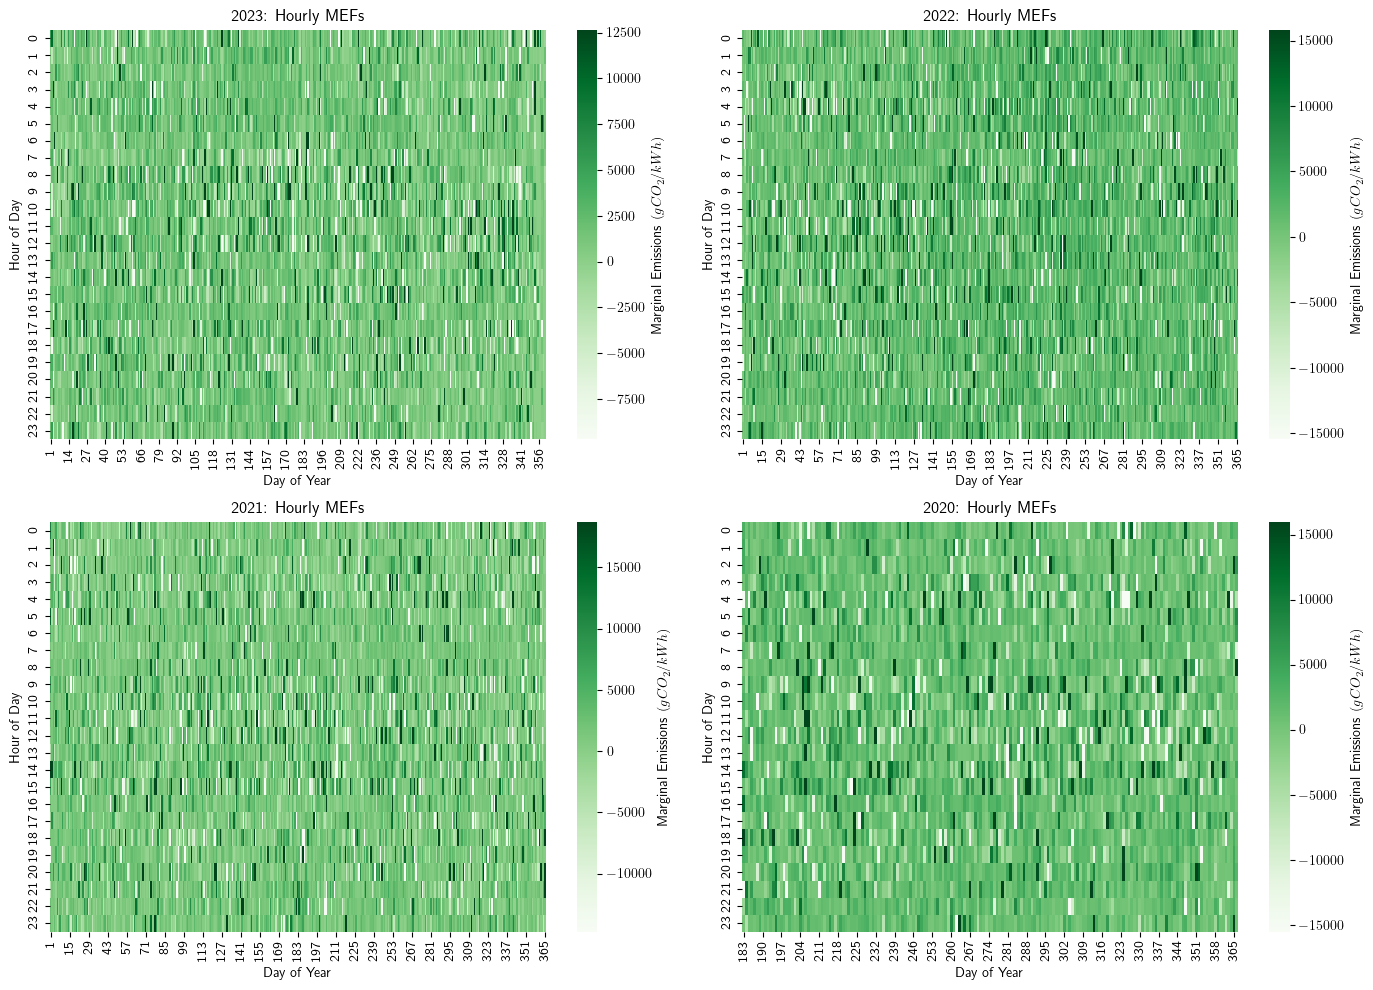

In [4]:
df = eirgrid.copy()
df['Year'] = df['EffectiveTime'].dt.year
df['DayOfYear'] = df['EffectiveTime'].dt.dayofyear
df['HourOfDay'] = df['EffectiveTime'].dt.hour # convert to float to represent quarter hours

years = df['Year'].unique()

# Create a figure with subplots - one for each year
nrows = math.ceil(len(years) / 2)
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(7 * nrows, 10))
for i, year in enumerate(years):
    # Pivot the dataframe to get the 'HourOfDay' as y-axis and 'DayOfYear' as x-axis
    heatmap_data = df[df['Year'] == year].pivot_table(
        values='MarginalEmissions', 
        index='HourOfDay', 
        columns='DayOfYear', 
        aggfunc='sum'
    ).fillna(0)
    ax = axes.flatten()[i]
    qt = heatmap_data.quantile(0.9)

    sns.heatmap(
        heatmap_data,
        cmap=sns.color_palette("Greens", as_cmap=True),
        robust=True,
        ax=ax,
        cbar_kws={'label': 'Marginal Emissions $(gCO_2 / kWh)$'}
    )

    # Plot the heatmap
    ax.set_title(f"{year}: Hourly MEFs")
    ax.set_xlabel('Day of Year')
    ax.set_ylabel('Hour of Day')


# Tight layout to prevent overlap
plt.tight_layout()
plt.show()

### Rolling Average

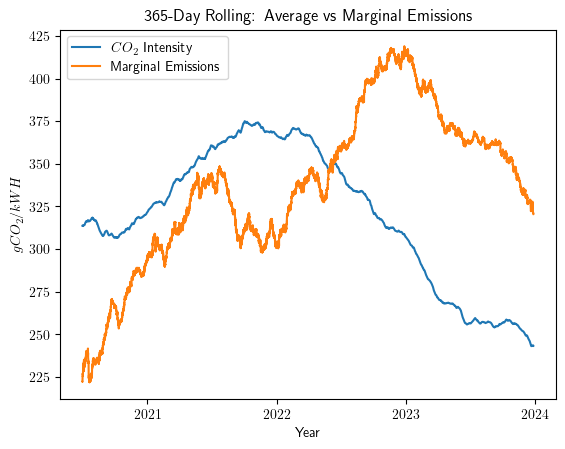

In [5]:
import matplotlib.dates as mdates

df = eirgrid.copy()
df = df.reindex(columns=['EffectiveTime', 'Co2Intensity', 'MarginalEmissions'])
df = df.set_index('EffectiveTime')


window = 365
plt.figure()
plt.plot(df.index, df['Co2Intensity'].rolling(f'{window}D', center=True).mean())
plt.plot(df.index, df['MarginalEmissions'].rolling(f'{window}D', center=True).mean())
plt.legend(['$CO_2$ Intensity', 'Marginal Emissions'])
plt.xlabel('Year')
plt.ylabel('$gCO_2/kWH$')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title(f'{window}-Day Rolling: Average vs Marginal Emissions')
plt.show()


### Generation Mix

58224     880.103448
58225    3734.000000
58226     453.008850
58227     352.418182
58228     298.000000
58229     459.300000
58230     418.222222
58231    -328.200000
58232     923.400000
58233     604.483871
58234     482.963636
58235     581.052632
58236     442.060773
58237     388.304348
58238      61.812500
58239     246.244186
58240    -538.076923
58241     283.000000
58242    -200.138462
58243    -797.176471
58244    -583.250000
58245    -129.782609
58246     256.000000
58247    4694.000000
58248      86.500000
58249     611.634615
58250     975.941176
58251     512.750000
58252     427.891892
58253      42.840000
58254   -2459.666667
58255    1541.666667
58256     446.833333
58257     370.123077
58258     924.769231
58259     301.165414
58260     573.218182
58261    6451.666667
58262     219.000000
58263     104.278481
58264     163.000000
58265     422.902439
58266     355.482759
58267     282.463415
58268    1032.888889
58269     347.121951
58270     236.568807
58271     264

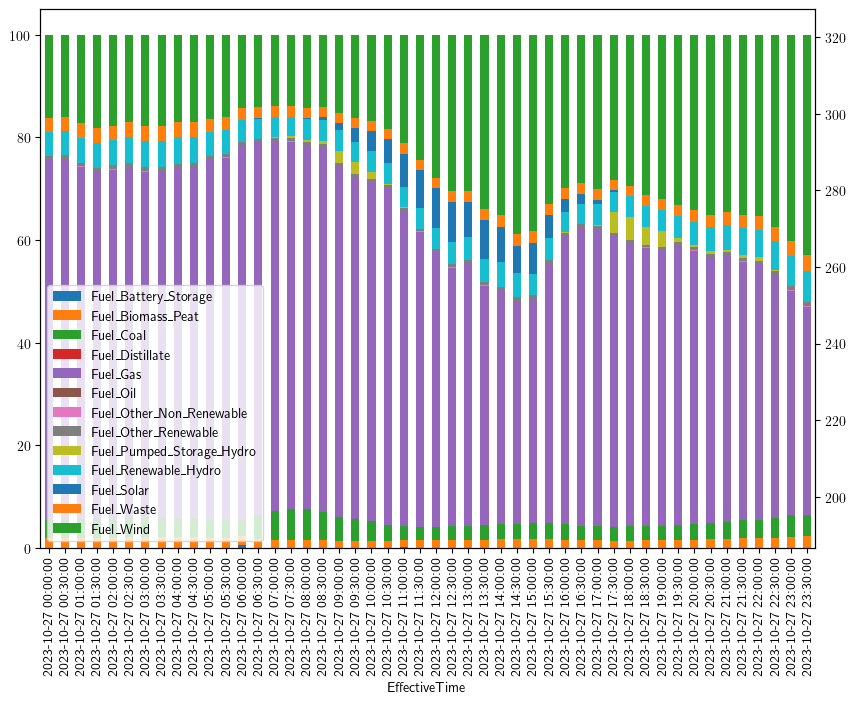

In [48]:
import datetime
fuel_mix = pd.read_csv(k.PROCESSED_DATA_DIR / 'fuel_mix.csv', index_col=0)
fuel_mix.rename(columns={'StartTime': 'EffectiveTime'}, inplace=True)
fuel_mix['EffectiveTime'] = pd.to_datetime(fuel_mix['EffectiveTime'])
fuel_mix = fuel_mix.set_index('EffectiveTime')

df = eirgrid.copy().set_index('EffectiveTime')
df = df.resample('30T').asfreq()
df = df.reset_index()

date = datetime.date(2023, 10, 27)
sys_fuel = fuel_mix.loc[fuel_mix.index.date == date]
sys_df = df.loc[df['EffectiveTime'].dt.date == date]
display(sys_df['MarginalEmissions'])

total = sys_fuel.sum(axis=1)
per = sys_fuel.div(total, axis=0).mul(100).round(2)
ax = per.plot(kind='bar', stacked=True, figsize=(10,7))

tx = ax.twinx()
tx.plot(sys_fuel.index, sys_df['Co2Intensity'])
# fuel_mix.loc[fuel_mix.index.date == date].plot(kind='bar', stacked=True, ax=ax)

# ax.xaxis.set_major_locator(mdates.HourLocator())
# plt.title('Half-hourly Fuel Mix')
# plt.xlabel('Time')
# plt.ylabel('Fuel Quantity')
# plt.xticks(rotation=45)
# plt.legend(title='Fuel Types')
# plt.show()